In [1]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians
from data import listedEiggHotels, pointsOfInterest, residentialEntry
from utils import *
from data import *
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

# Residences

This notebook takes a look at any potential correlations between residence location and observations between animals

In [2]:
# Merge anything within 10 m of each other
def cleanResidences(curr):
    curr = curr.keys()
    curr = list(map(lambda x: x.split(","),curr))
    curr = list(map(lambda x: [float(x[0]),float(x[1])], curr))
    new = []
    
    for k in curr:
        broken = False
        for item in new:
            d = seperationInMetres(k,item)
            if d < 30:
                broken = True
                break
        if not broken:
            new.append(k)
    
    return new

def cleanObs(locs):
    new = []
    
    for k in locs:
        broken = False
        for key, val in enumerate(new):
            item,count = val
            d = seperationInMetres(k,item)
            if d < 1:
                broken = True
                new[key] = [item,count+1]
                break
        if not broken:
            new.append([k,1])
    
    return new
        
residences = cleanResidences(residentialEntry())
print(len(residences))

30


In [3]:
def graphTwoSetsByObservations(buildingLocs,obsLocs,dist=500):
    distance_away = dist

    G = nx.Graph()

    colorMap = (['gold'] * len(buildingLocs)) + (['blue'] * len(obsLocs))

    for k,r in enumerate(buildingLocs):
        G.add_node(k, color="green")

    for k,o in enumerate(obsLocs):
        G.add_node(k+len(buildingLocs), color="blue")

    for o_index,o in enumerate(obsLocs):
        for r_index,r in enumerate(buildingLocs):
            if seperationInMetres(o,r) < distance_away:
                G.add_edge(o_index+len(buildingLocs),r_index)
                
    return G, colorMap


In [4]:
data = pd.read_csv("eigg.csv") 
data.head()

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NBN Atlas record ID,Occurrence ID,Licence,Rightsholder,Scientific name,Common name,Species ID (TVK),Taxon Rank,Occurrence status,Start date,...,Class,Order,Family,Genus,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Country,State/Province
0,baa00bca-011f-43bf-b3e2-4ea60f04646e,3783,CC-BY-NC,Buglife,Meloe violaceus,Violet Oil-beetle,NBNSYS0000024952,species,present,28/06/1905,...,Insecta,Coleoptera,Meloidae,Meloe,NM,NM48,NM48T,NM4686,United Kingdom,Scotland
1,f70cff95-1d0d-4dbd-bece-10239bad0a93,232100298,CC0,NaN,Rhantus suturellus,NaN,NBNSYS0000007613,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Rhantus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
2,f450fbce-7e45-4822-ada4-0591c7ea0b48,232100297,CC0,NaN,Gyrinus substriatus,NaN,NBNSYS0000007643,species,present,11/09/1910,...,Insecta,Coleoptera,Gyrinidae,Gyrinus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
3,e6ceb7fa-7437-490f-a93e-862872492660,232100292,CC0,NaN,Enochrus fuscipennis,NaN,NHMSYS0001718079,species,present,11/09/1910,...,Insecta,Coleoptera,Hydrophilidae,Enochrus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
4,e6649320-d64b-4c29-8393-5565655f0ff9,232100296,CC0,NaN,Boreonectes multilineatus,NaN,NHMSYS0021125444,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Boreonectes,NM,NM48,NM48N,NM4486,United Kingdom,Scotland


In [5]:
df = data[['Recorder', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Start date year']]

df = df.dropna(subset=['Latitude (WGS84)'])
df = df.dropna(subset=['Longitude (WGS84)'])
df["Latitude (WGS84)"] = df["Latitude (WGS84)"].astype(np.float32)
df["Longitude (WGS84)"] = df["Longitude (WGS84)"].astype(np.float32)

df = df.dropna(subset=['Start date year'])
df["Start date year"] = df["Start date year"].astype(np.int32)
df = df[(df['Start date year'] > 2010.0)]

print(len(df['Recorder']))

5394


In [6]:
observationLocs = list(zip(df['Latitude (WGS84)'], df['Longitude (WGS84)']))
print(len(observationLocs))
observationLocs = cleanObs(observationLocs) 
print(len(observationLocs))

5394
293


In [7]:
# Assume 1 observation = outlier

In [8]:
observationLocs = list(filter(lambda x: x[1] > 2,observationLocs))
print(len(observationLocs))
observationLocs = list(map(lambda x: x[0],observationLocs))

74


In [9]:
len(residences),len(observationLocs)

(30, 74)

In [10]:
Gr, colorMap = graphTwoSetsByObservations(residences,observationLocs)

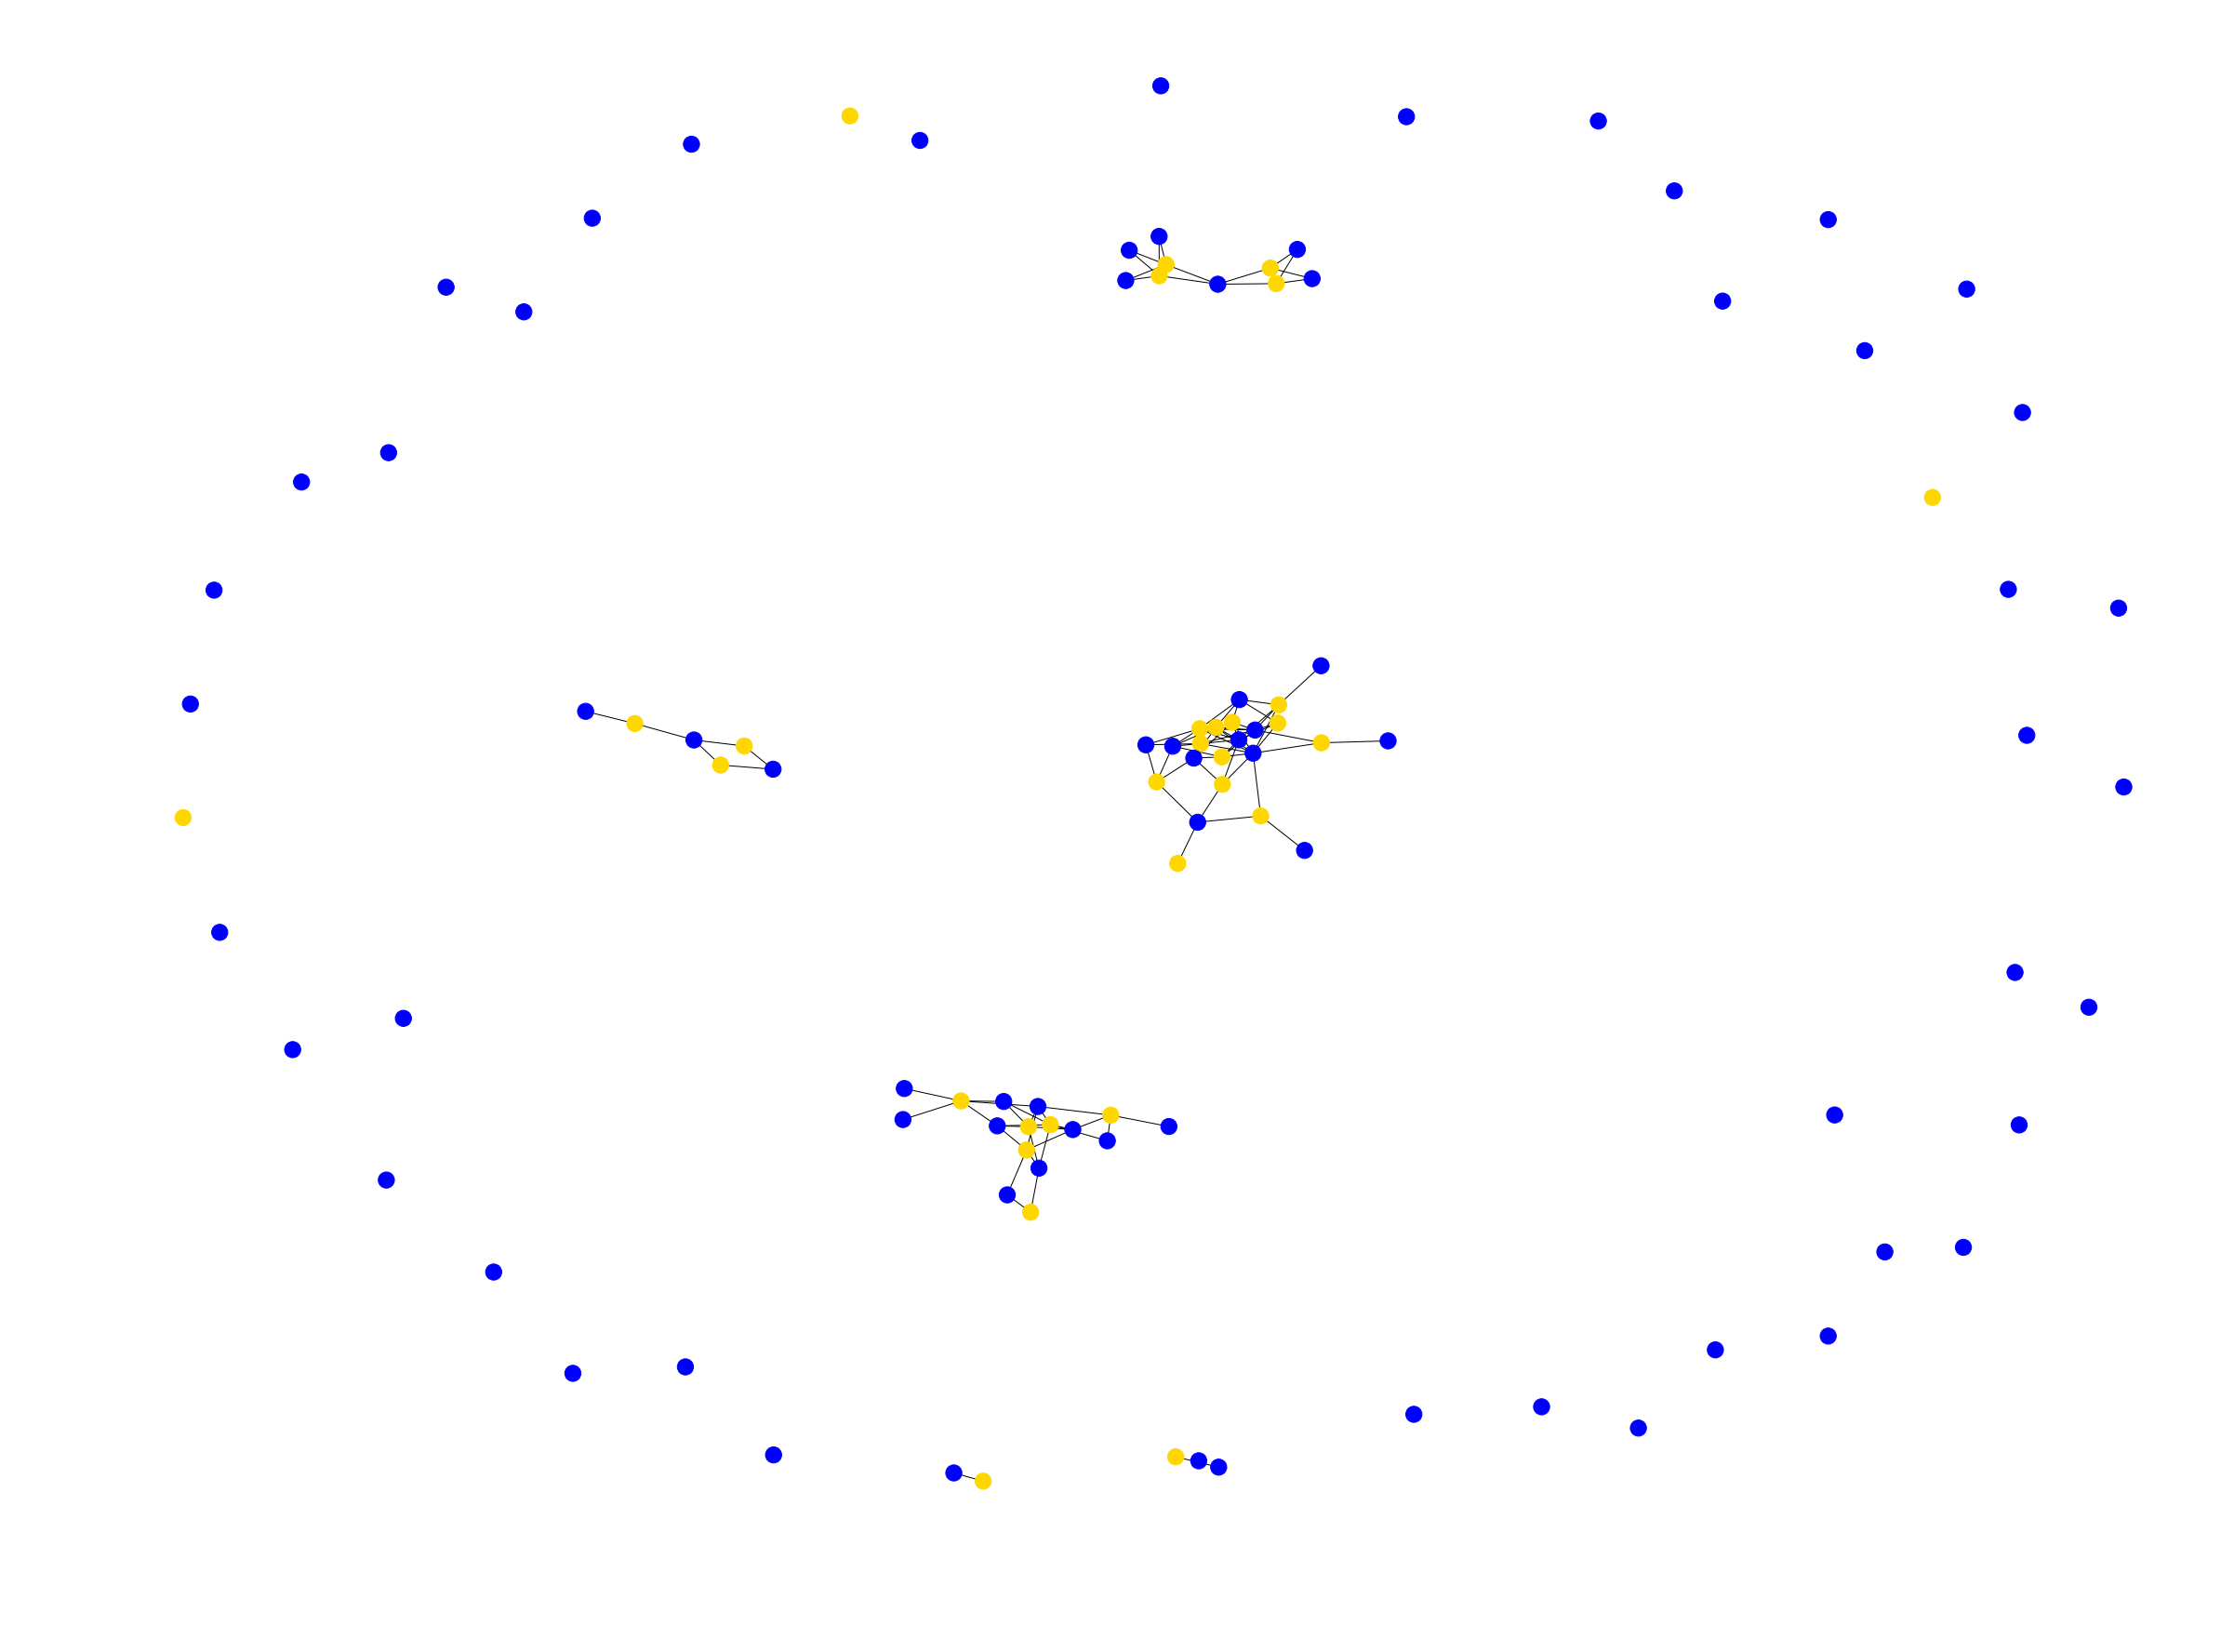

In [11]:
nx.draw(Gr, node_color=colorMap)

In [13]:
# observationLocsNF = list(map(lambda x: (float(x[0]),float(x[1])),observationLocs))
# residencesNF = list(map(lambda x: (float(x[0]),float(x[1])),residences))
saveGraphToFile(Gr,"ResVSEco.txt")
# generateMapJSON([('./fullColMarkers/marker2.png',observationLocsNF),('./fullColMarkers/marker76.png',residencesNF)],[(observationLocsNF+residencesNF,Gr)],"residencesVSobservations.txt")

(104, 104)



In [ ]:
file = nx.to_numpy_matrix(G)
print(file.shape)
print()
print(file)
np.savetxt("ResObsProximity.txt",file, "%d")   

###  Same, but on hotels vs Obs

In [14]:
observationLocs = list(zip(df['Latitude (WGS84)'], df['Longitude (WGS84)']))
print(len(observationLocs))
observationLocs = cleanObs(observationLocs) 
print(len(observationLocs))
observationLocs = list(filter(lambda x: x[1] > 2,observationLocs))
print(len(observationLocs))
observationLocs = list(map(lambda x: x[0],observationLocs))

hotels = cleanResidences(listedEiggHotels())

5394
293
74


In [15]:
len(hotels), len(observationLocs) 

(17, 74)

In [16]:
Gh, colorMap = graphTwoSetsByObservations(observationLocs,hotels)

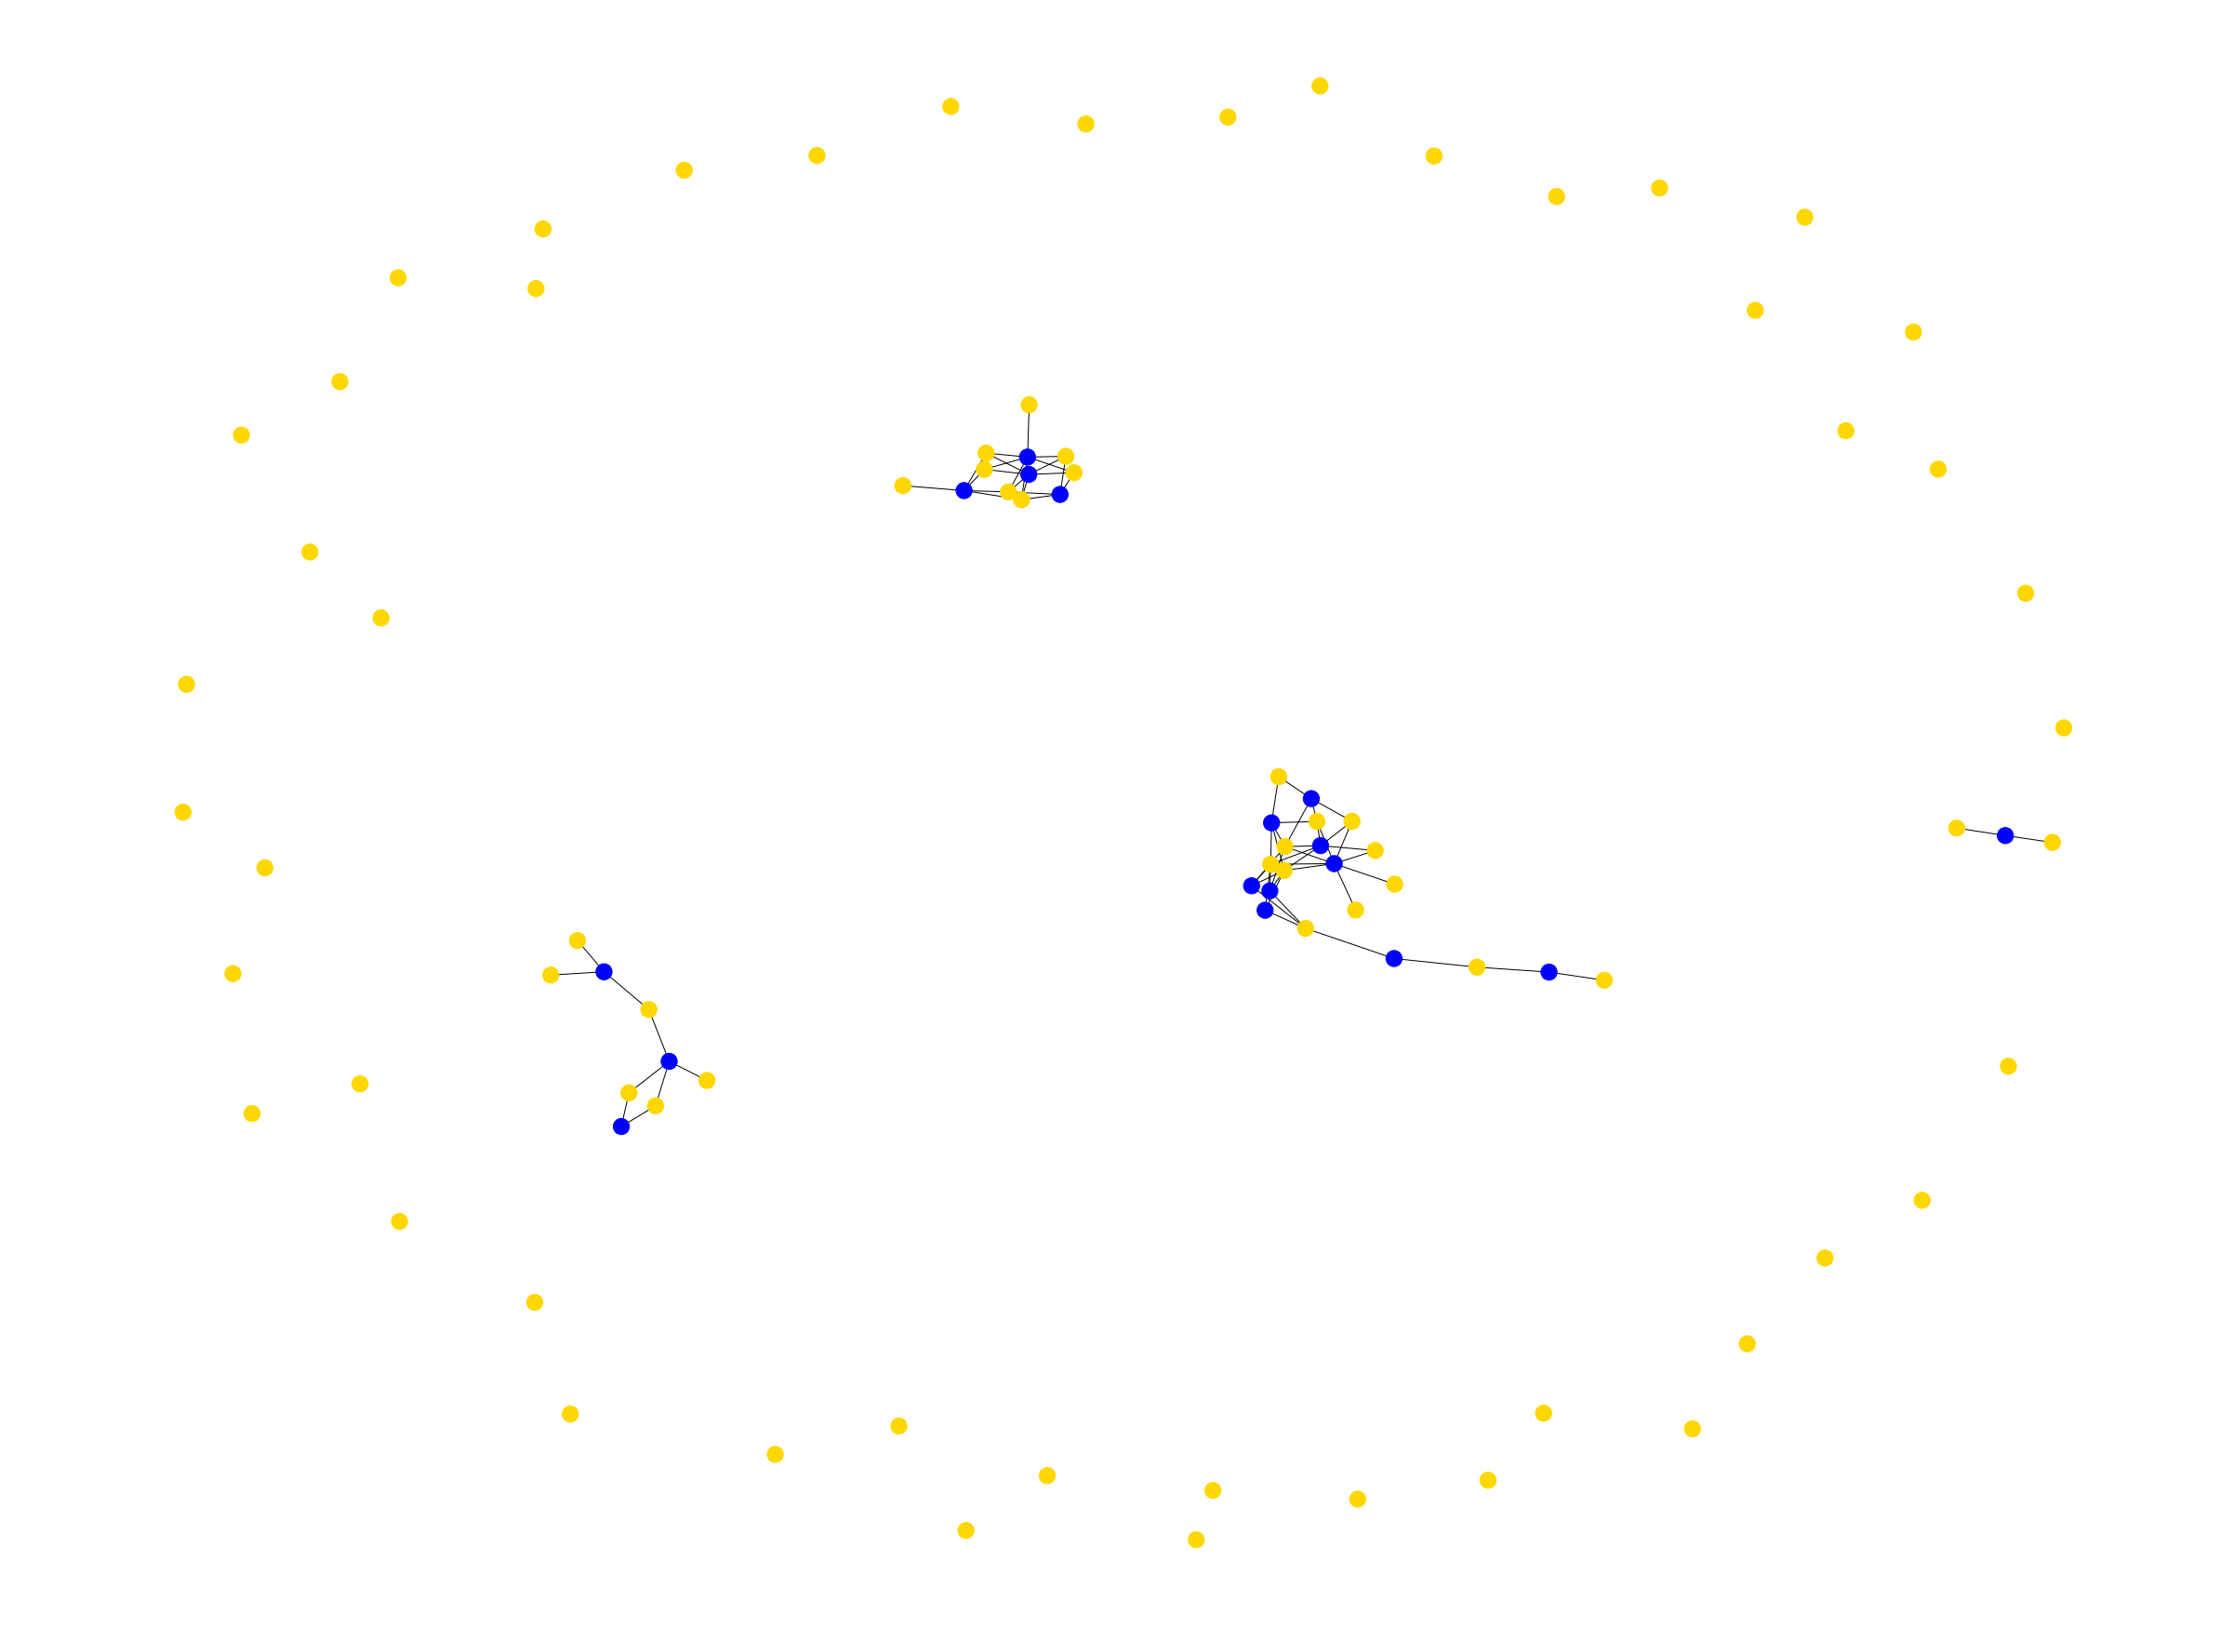

In [17]:
nx.draw(Gh, node_color=colorMap)

In [18]:
Gt, colorMap = graphTwoSetsByObservations(residences,hotels)

In [20]:
saveGraphToFile(Gt,"ResVsHotels.txt")

(47, 47)



In [ ]:
nx.draw(Gt, node_color=colorMap)

In [ ]:
residences = ('./fullColMarkers/marker73.png',toUsableLatLonList(residentialEntry().keys()))
hotels = ('./fullColMarkers/marker76.png',toUsableLatLonList(listedEiggHotels().keys()))
generateMapJSON([residences,hotels],[],'residencesOnHotels.txt')

In [ ]:
print(Gt.number_of_edges())
print(Gh.number_of_edges())
print(Gr.number_of_edges())

# Extra- "Points of interest" comparison

Refer to notes regarding impact

In [ ]:
observationLocs = list(zip(df['Latitude (WGS84)'], df['Longitude (WGS84)']))
print(len(observationLocs))
observationLocs = cleanObs(observationLocs) 
print(len(observationLocs))
observationLocs = list(filter(lambda x: x[1] > 2,observationLocs))
print(len(observationLocs))
observationLocs = list(map(lambda x: x[0],observationLocs))

interests = cleanResidences(pointsOfInterest())

In [ ]:
Gi, colorMap = graphTwoSetsByObservations(observationLocs,interests)

In [ ]:
nx.draw(Gi, node_color=colorMap)

In [ ]:
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)

In [ ]:
nx.draw(Goi, node_color=colorMap)

In [ ]:
Gri, colorMap = graphTwoSetsByObservations(residences,interests)
nx.draw(Gri, node_color=colorMap)